In [1]:

from rewards import ConstantRewardGenerator, NormalNoiseRewardGenerator, ValueNoiseRewardGenerator, BrownianMotionRewardGenerator
from policies import GreedyPolicy, EpsilonGreedyPolicy
from policies import BTSampleMean, BTEMAConst, BTEMA, BTUCB
from karm import KArmedBandit

import numpy as np
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)

MAX_PRINT_TRIALS = 5
n_trials = 2000
k = 10
len_trial = 1000

# Effect of Epsilon Greedy
# policiesBase = {
#     "greedy": GreedyPolicy( BTSampleMean(k) ),
# }
# epsilons = [0.01, 0.10]
# for eps in epsilons: 
#     policiesBase[f"eps{eps}"] = EpsilonGreedyPolicy(eps, BTSampleMean( k ))

# alpha = .1
# epsilon = .1
# policiesBase = {
#     "sm":  EpsilonGreedyPolicy( epsilon, BTSampleMean(k) ),
#     "emaConst": EpsilonGreedyPolicy( epsilon, BTEMAConst(k, epsilon) ),
#     "ema": EpsilonGreedyPolicy( epsilon, BTEMA(k, epsilon) ),
# }

### Optimistic Greedy vs Base
# policiesBase = {
#     "eps0.01"   : EpsilonGreedyPolicy(0.01, BTSampleMean( k ) ),
#     "eps0.01opt": EpsilonGreedyPolicy(0.01, BTSampleMean( k, prior = np.ones( k ) * 5 ) ),
# }

### Epsilon Greedy versus UCB 
policiesBase = {
    "ucb": GreedyPolicy( BTUCB( BTSampleMean(k), c=2 ) ),
    "eps0.1"   : EpsilonGreedyPolicy(0.1, BTSampleMean( k ) ),
    "eps0.1opt": EpsilonGreedyPolicy(0.1, BTSampleMean( k, prior = np.ones( k ) * 5 ) ),
}

policyNames = list( sorted( set( policiesBase.keys() ) ) )
nPolicies = len( policyNames )

rewardMeansExp = np.random.normal( 0, 1, size=(n_trials, k) )
rewardPathsExp = np.zeros( ( n_trials, len_trial, nPolicies ) )
optimlPathsExp = np.zeros( ( n_trials, len_trial, nPolicies ) )
for itrial in range( n_trials ):
    rewardMeans = rewardMeansExp[itrial]
    rewardGenerators = [ ValueNoiseRewardGenerator( 
                            valueGen=ConstantRewardGenerator(rm),
                            # valueGen=BrownianMotionRewardGenerator(0.01),
                            noiseGen=NormalNoiseRewardGenerator(0,1)
                        ) for rm in rewardMeans ]
    # rewardGenerators = [ ValueNoiseRewardGenerator( 
    #                         # valueGen=ConstantRewardGenerator(rm),
    #                         valueGen=BrownianMotionRewardGenerator(0.01),
    #                         noiseGen=ConstantRewardGenerator(0.0),
    #                     ) for rm in rewardMeans ]
    bandit = KArmedBandit( rewardGenerators )
    policies = deepcopy( policiesBase )
    lstRewards = np.zeros( nPolicies ) 
    curRewards = np.zeros( nPolicies )
    lstChoices = np.zeros( nPolicies ) 
    curChoices = np.zeros( nPolicies )
    if n_trials <= MAX_PRINT_TRIALS:
        print( np.array( [ r.get_value() for r in bandit.rewards ] ) )
    for i in range(len_trial):
        optimalArm = bandit.optimal_arm()
        for ipol, name in enumerate(policyNames):
            policy = policies[name] 
            if name == "ucb" and n_trials <= MAX_PRINT_TRIALS: 
                print( policy.choice(), policy.bt.get_parameters() )
            arm = policy.choice()
            reward = bandit.query_arm( arm )
            policy.update( arm, reward )
            curRewards[ipol] = reward
            curChoices[ipol] = arm
        bandit.step()
        curChoicesBool = curChoices == optimalArm

        # if i == 0: 
        #     rewardPathsExp[itrial,i,:] = curRewards
        #     optimlPathsExp[itrial,i,:] = curChoicesBool.astype(float)
        # else:
        #     rewardPathsExp[itrial,i,:] = lstRewards + (curRewards - lstRewards) / i
        #     optimlPathsExp[itrial,i,:] = lstChoices + (curChoicesBool - lstChoices) / i
        rewardPathsExp[itrial,i,:] = curRewards
        optimlPathsExp[itrial,i,:] = curChoicesBool.astype(float)

        lstRewards = rewardPathsExp[itrial,i,:].copy()
        lstChoices = optimlPathsExp[itrial,i,:].copy()
    # for ipol, _ in enumerate( policyNames ): 
    #     rewardPathsExp[itrial, :, ipol] = rewardPathsExp[itrial, :, ipol].cumsum()
    #     rewardPathsExp[itrial, :, ipol] /= np.arange(rewardPathsExp[itrial, :, ipol].shape[0]) + 1

    # for ipol, name in enumerate(policyNames):
    #     policy = policies[name] 
    #     print( name )
    #     print( policy.nSampled )
    #     print( policy.meanRewards )

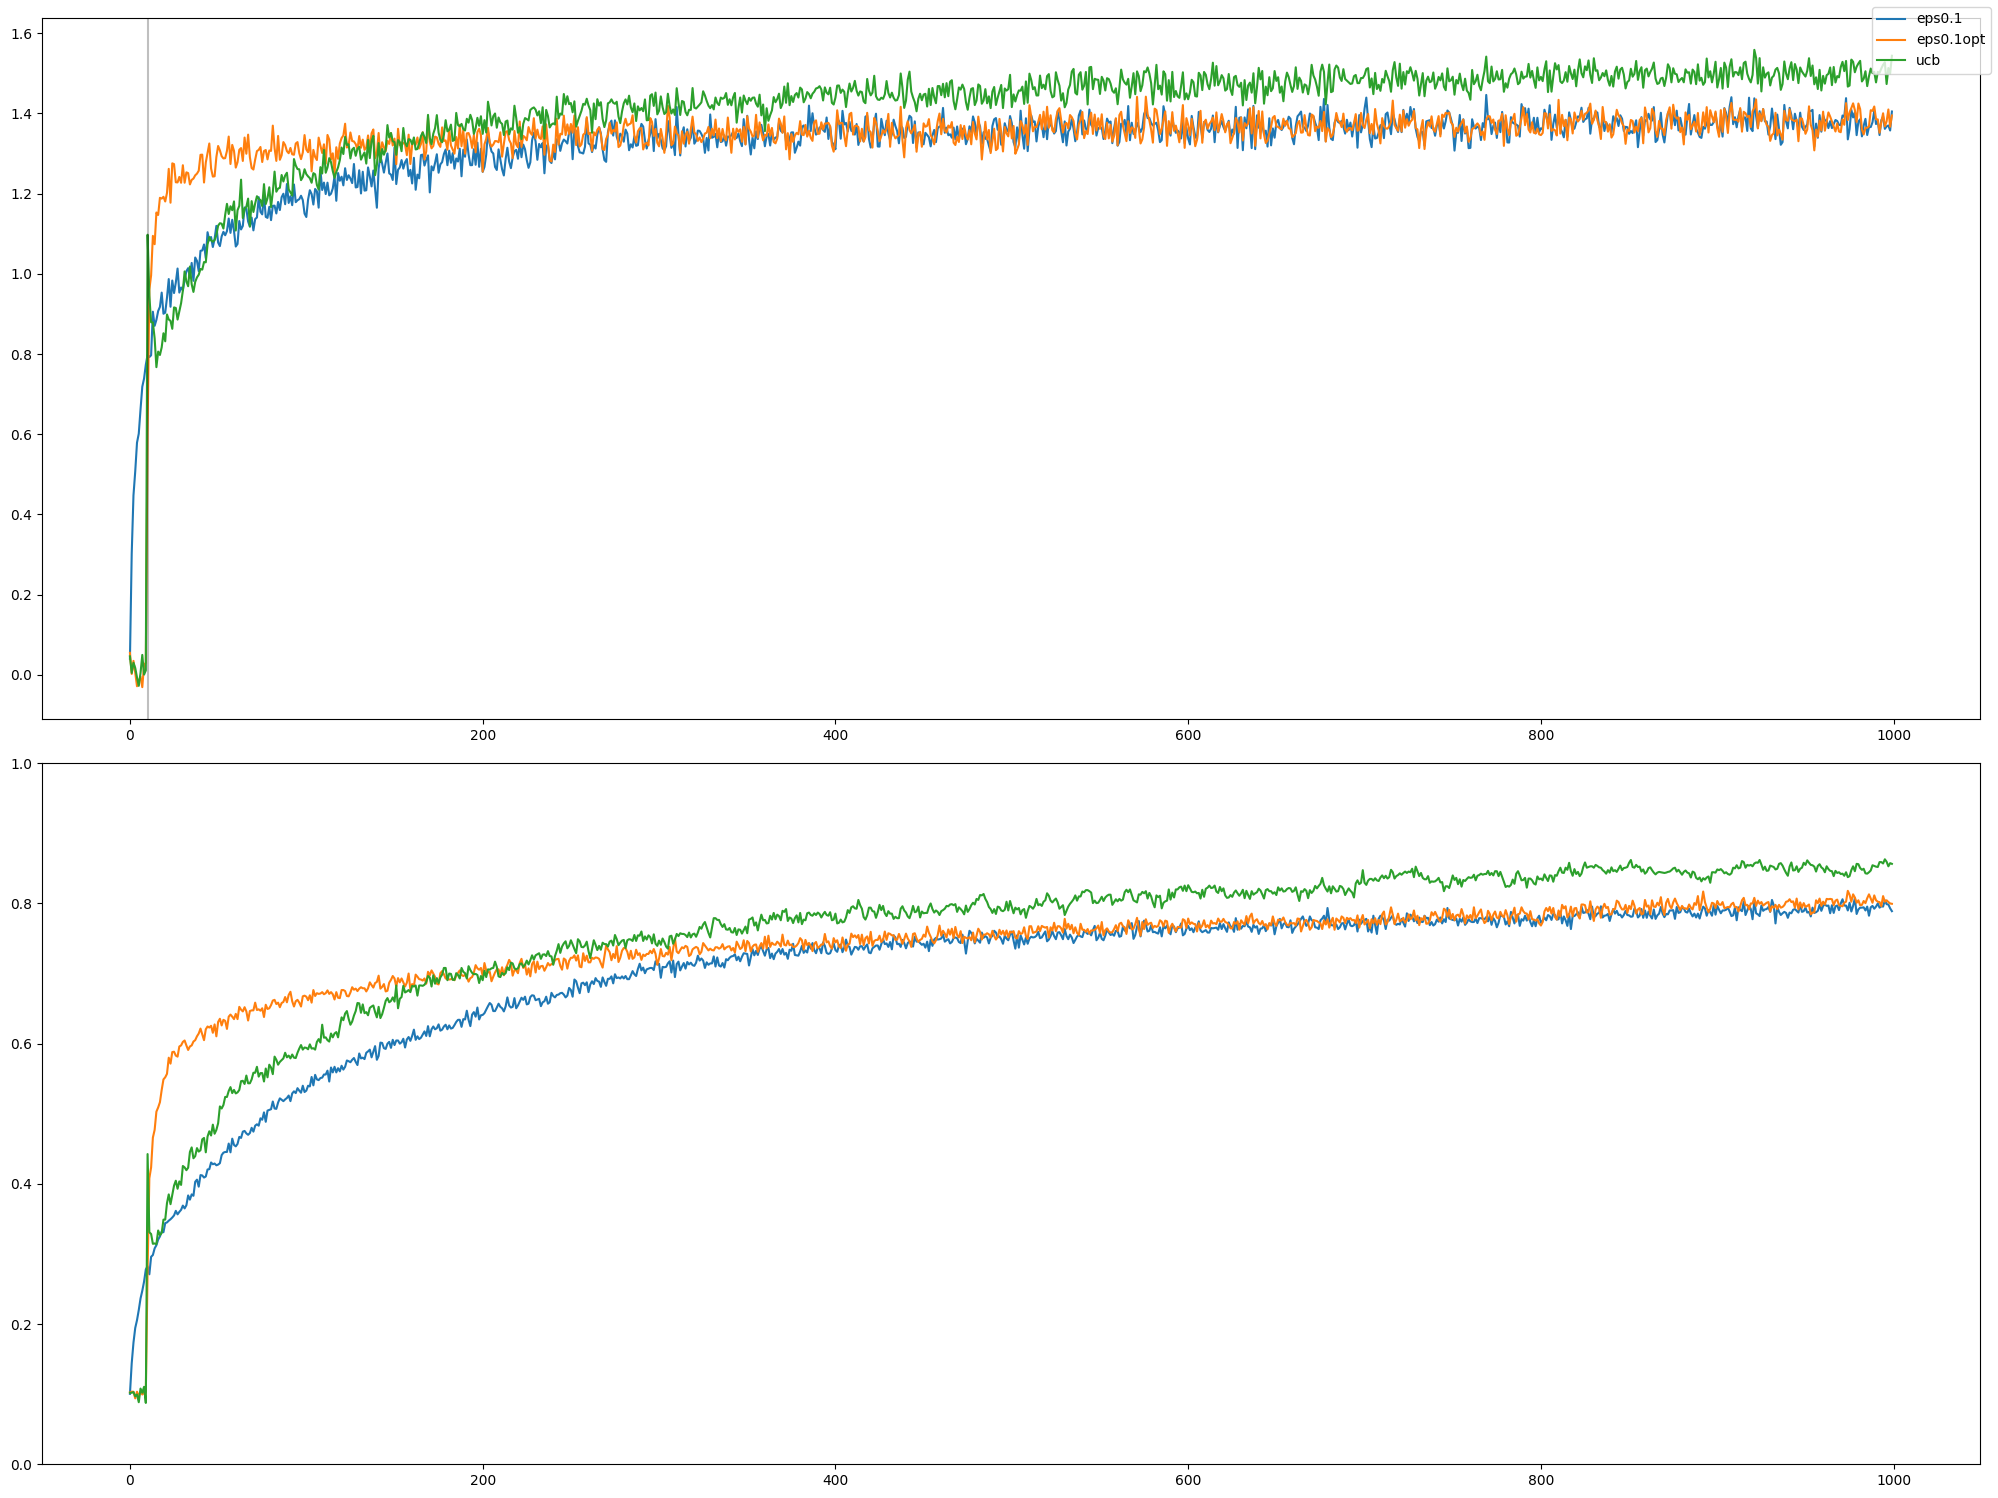

In [2]:
fig, axs = plt.subplots( nrows = 2 )
for ipol, name in enumerate( policyNames ):
    rewards = rewardPathsExp[:, :, ipol].mean(axis = 0)
    optfrac = optimlPathsExp[:, :, ipol].mean(axis = 0)
    axs[0].plot( rewards, label=name )
    axs[1].plot( optfrac )

axs[0].axvline( k, color = "black", alpha = .25 )
axs[1].set_ybound(0, 1)

fig.tight_layout()
fig.legend()

plt.show()

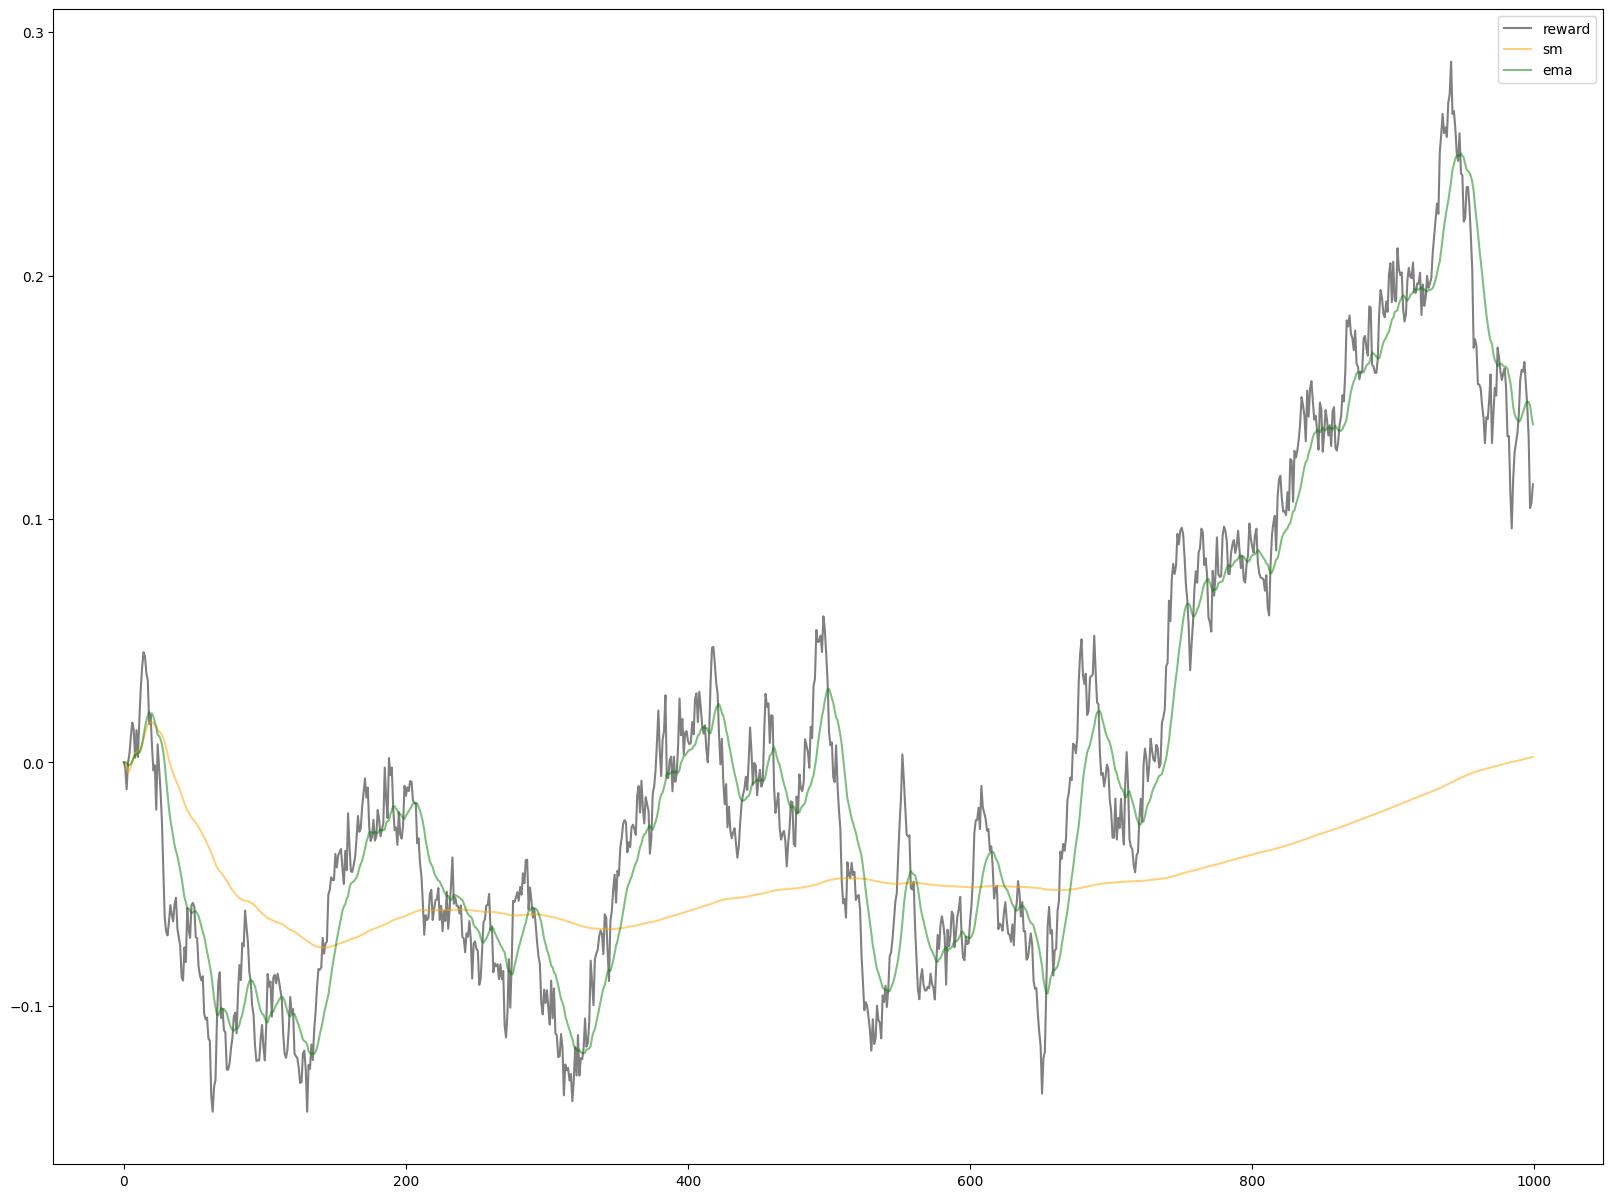

In [3]:
rewardGen = BrownianMotionRewardGenerator(0.01)
sm        = BTSampleMean( 1 )
ema       = BTEMA( 1, .1 )
rs = np.zeros(len_trial)
sms = np.zeros(len_trial)
emas = np.zeros(len_trial)
for i in range(len_trial):
    r = rewardGen.get_reward()
    sms[i] = sm.get_parameters()[0]
    emas[i] = ema.get_parameters()[0]
    rs[i] = r
    sm.update_parameters( 0, r )
    ema.update_parameters( 0, r )
    rewardGen.step()
plt.plot( rs, label = "reward", color = "grey" )
plt.plot( sms, label = "sm", color = "orange", alpha = .5 )
plt.plot( emas, label = "ema", color = "green", alpha = .5 )
plt.legend()
plt.show()

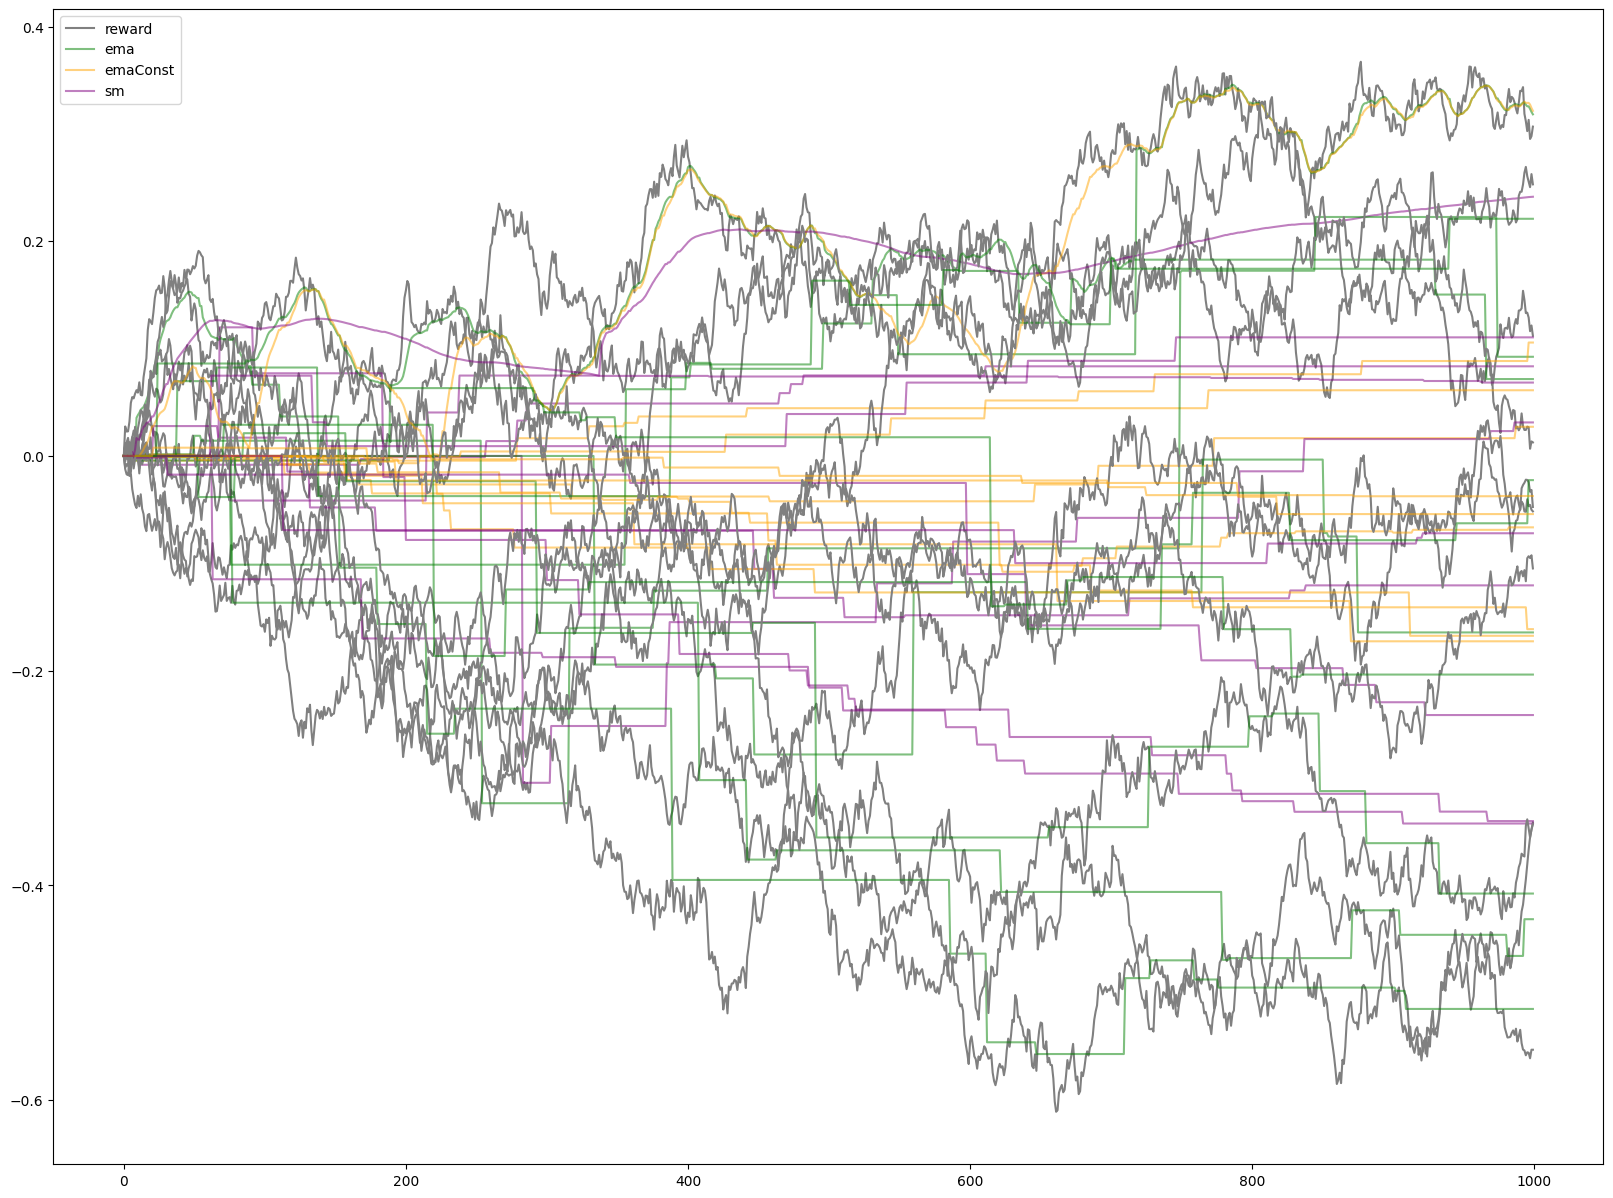

In [4]:
k = 10
bandit = KArmedBandit( [BrownianMotionRewardGenerator(0.01) for _ in range(k) ] )
policies = {
    "sm": EpsilonGreedyPolicy( .1, BTSampleMean( k ) ),
    "emaConst": EpsilonGreedyPolicy( .1, BTEMAConst( k, .1 ) ),
    "ema": EpsilonGreedyPolicy( .1, BTEMA( k, .1 ) ),
}
policyKeys = list(sorted(set(policies.keys())))
policyEsts = { key: np.zeros((len_trial,k)) for key in policies.keys() }
colors = ["green", "orange", "purple"]
rs = np.zeros((len_trial,k))
for i in range(len_trial):
    rs[i] = [r.get_reward() for r in bandit.rewards]
    for key, policy in policies.items():
        policyEsts[key][i] = policy.bt.get_parameters()
        arm = policy.choice()
        r = bandit.query_arm(arm)
        policy.update( arm, r )
    bandit.step()

for i in range(k):
    if i == 0:
        plt.plot( rs[:,i], label = "reward", color = "grey" )
        for j, key in enumerate( policyKeys ):
            plt.plot( policyEsts[key][:,i], label = key, color = colors[j], alpha = .5 )
    else: 
        plt.plot( rs[:,i], color = "grey" )
        for j, key in enumerate( policyKeys ):
            plt.plot( policyEsts[key][:,i], color = colors[j], alpha = .5 )
plt.legend()
plt.show()